In [1]:
import ujson

with open("./datasets/MSRA-TD500/annotations.json", "r") as f:
    annotations = ujson.load(f)

In [2]:
from utils.visualization import imshow, bi_imshow

In [3]:
import cv2
import numpy as np

# trainning data

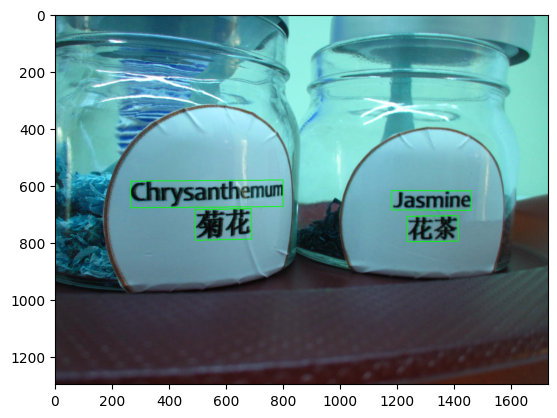

In [4]:
# chéo sắc 3, chéo quyền 23, bình thường 2
index = 2
path = f"./datasets/MSRA-TD500/train/{annotations['train'][index]['img_name']}"

image = cv2.imread(path)
boxes = annotations['train'][index]['boxes']

text_polygons = []
for box in boxes:
    idx, difficult, x, y, h, w, theta, polylines= box.values()     
    points = np.array([polylines])  
    cv2.polylines(image, points, isClosed=True, color=(0, 255, 0), thickness=2)

    text_polygons.append(points)
imshow(image)

In [5]:
# for i in range(30):
#     index = i
#     path = f"./datasets/MSRA-TD500/train/{annotations['train'][index]['img_name']}"
#     image = cv2.imread(path)
#     boxes = annotations['train'][index]['boxes']

#     text_polygons = []
#     for box in boxes:
#         idx, difficult, x, y, h, w, theta, polylines= box.values()     
#         points = np.array([polylines])  
#         cv2.polylines(image, points, isClosed=True, color=(0, 255, 0), thickness=2)

#         text_polygons.append(points)
#     imshow(image)

In [ ]:
from models.detection.utils import generate_quad, decode_quad, four_point_transform, resize_and_pad, generate_score_mask

# process data

In [15]:
index = 2
path = f"./datasets/MSRA-TD500/train/{annotations['train'][index]['img_name']}"

image = cv2.imread(path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image, raito = resize_and_pad(image)
# boxes
text_polygons=[]
for box in annotations['train'][index]['boxes']:
    text_polygons.append((np.array(box['polylines'])*raito).astype(int))


# score_maps_gt, geo_maps_gt, training_masks = generate_quad((image.shape[0], image.shape[1]), text_polygons)

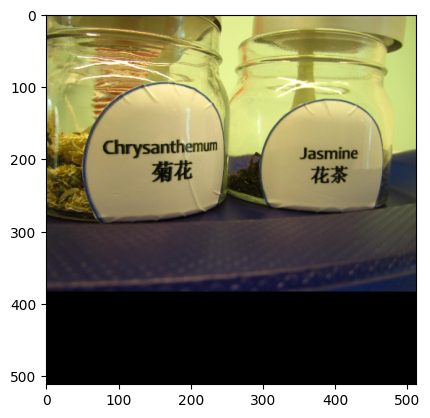

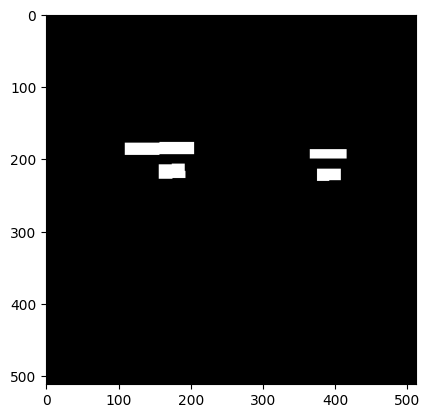

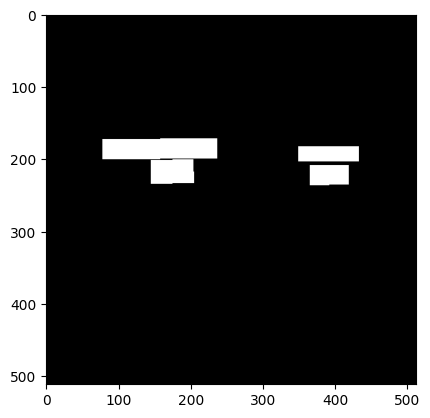

In [16]:
score, mask = generate_score_mask((image.shape[0], image.shape[1]), text_polygons) 
imshow(image)
bi_imshow(score)
bi_imshow(mask)

# detection

In [9]:
# from models.detection.model import EAST
# model = EAST()

In [ ]:
from PIL import Image
# import torchvision.transforms as transforms
# import torch

# transform = transforms.Compose([
#     transforms.ToTensor(),  # Chuyển đổi PIL Image thành tensor (kênh từ [0, 255] thành [0, 1])
# ])

# image = Image.open(path)
# image = transform(image)
# image = image.unsqueeze(0)

# model.eval()  # Chuyển sang chế độ đánh giá nếu chỉ inference
# with torch.no_grad():  # Tắt tính toán gradient để tiết kiệm tài nguyên
#     score_pred, geo_pred = model(image)
# score, geo = score_pred.numpy()[0][0], geo_pred.numpy()[0][0]

In [ ]:
# polygons = decode_quad(score, geo)

In [18]:
# image = cv2.imread(path)

# for box in polygons:
#     points = np.array(box).astype(int).reshape(1,-1,2) 
#     cv2.polylines(image, points, isClosed=True, color=(0, 255, 0), thickness=2)

# imshow(image)

# regonition's inputs

In [19]:
# image = cv2.imread(path)

# for box in polygons:
#     points = np.array(box).astype(int).reshape(-1,2) 

#     wraped = four_point_transform(image, points) # OCR's inputs
#     imshow(wraped)

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.models as models
# CNN Backbone (ResNet18 với thay đổi)
class CNNBackbone(nn.Module):
    def __init__(self, output_dim=512):
        super(CNNBackbone, self).__init__()
        # Sử dụng ResNet18 làm backbone hoặc xây dựng CNN từ đầu
        # Ví dụ sử dụng ResNet18 đã pre-trained nhưng chỉ lấy phần feature extraction
        resnet = models.resnet18(pretrained=True)
        # Bỏ lớp fully connected cuối cùng
        self.backbone = nn.Sequential(*list(resnet.children())[:-2])
        
        # Projection layer để biến đổi feature map thành dạng phù hợp với transformer
        self.projection = nn.Conv2d(512, output_dim, kernel_size=1)
        
    def forward(self, x):
        # x shape: [batch_size, 3, height, width]
        features = self.backbone(x)
        # features shape: [batch_size, 512, h', w']
        features = self.projection(features)
        # features shape: [batch_size, output_dim, h', w']
        
        # Reshape để phù hợp với transformer
        batch_size, c, h, w = features.shape
        features = features.permute(0, 2, 3, 1).contiguous()
        # features shape: [batch_size, h', w', output_dim]
        features = features.view(batch_size, h * w, c)
        # features shape: [batch_size, h'*w', output_dim]
        
        return features

In [14]:
a = torch.rand(1,3,32,512)
backbone = CNNBackbone()

/Users/hung/Desktop/OCR/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/hung/Desktop/OCR/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [15]:
a.shape

torch.Size([1, 3, 32, 512])

In [16]:
b = backbone(a)

In [17]:
b.shape

torch.Size([1, 16, 512])